In [1]:
import sys
sys.path.append('../')
import uPVT.PVT as PVT
import math
import matplotlib.pyplot as plt
import pandas as pd
import uSep.separation as sp

Result of separation check:
qgas_scm3day -work right
qo_scm3day -work right
unf_calc_natural_separation -work right
unf_calc_total_separation -work right


In [10]:
data = pd.read_excel('SepTestData.xlsx')

In [2]:
pintake_atm=80
q_sm3day=100
wct_perc=22
tintake_c=80
dintake_mm=100
dcasing_mm=125
gammagas=0.9
gammaoil=0.75
gammawater=1
rsb_m3m3=80
rp_m3m3=80
#qo_scm3day=50
#оптциональные/калибровочные параметры
pb_atm=150
tres_c=120
bob_m3m3=1
#qo_scm3day=50

In [3]:
fluid=PVT.FluidStanding(gammaoil,gammagas,gammawater,rsb_m3m3)
fluid.calc(pintake_atm,tintake_c)

1

In [4]:
def out(number,string):
    space=' - '
    print(str(number),space,string)
out(dintake_mm,'dintake_mm')
out(dcasing_mm,'dcasing_mm')
out(q_sm3day,'Qliq_scm3day')
out(fluid.bo_m3m3,'bo_m3m3')
out(fluid.bg_m3m3,'bg_m3m3')
out(fluid.sigma_oil_Nm,'sigma_oil_Nm')
out(fluid.rho_oil_stkgm3,'rho_oil_stkgm3')
out(fluid.rho_gas_sckgm3,'rho_gas_sckgm3')
out(wct_perc,'wct_perc')

100  -  dintake_mm
125  -  dcasing_mm
100  -  Qliq_scm3day
1.9522964869459403  -  bo_m3m3
0.012673883940723262  -  bg_m3m3
0.0  -  sigma_oil_Nm
750.0  -  rho_oil_stkgm3
1.1025  -  rho_gas_sckgm3
22  -  wct_perc


In [26]:
def getvalues(start=1,stop=300,step=10):
    q=[]
    sep=[]
    totalsep=[]
    for i in range(start,stop,step):
        q.append(i)
        sep.append(sp.unf_calc_natural_separation(dintake_mm/1000,dcasing_mm/1000,
                                       i,
                                       sp.qgas_scm3day(sp.qo_scm3day(i,wct_perc),rp_m3m3),fluid.bo_m3m3,
                                       fluid.bg_m3m3,
                                       200/1000,fluid.rho_oil_stkgm3,
                                       fluid.rho_gas_sckgm3,wct_perc))
      
              
    return [q,sep]

result=getvalues()


In [27]:
type(sp.qo_scm3day)

function

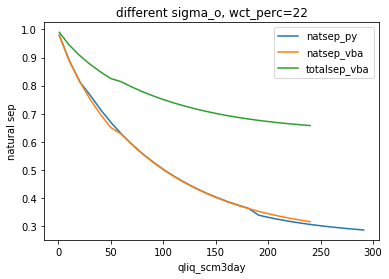

In [33]:
plt.plot(result[0],result[1],label='natsep_py')
plt.plot(data['Q'],data['Естественная сепарация 100 мм'],label='natsep_vba')
plt.plot(data['Q'],data['Общая сепарация'],label='totalsep_vba')
plt.ylabel('natural sep')
plt.xlabel('qliq_scm3day')
plt.title('different sigma_o, wct_perc=22')
plt.legend()
plt.show()

In [2]:
sp.separation_test()

qgas_scm3day work right
qo_scm3day work right
unf_calc_natural_separation work right


In [23]:
pintake_atm=80
q_sm3day=100
wct_perc=22
tintake_c=80
dintake_mm=100
dcasing_mm=125
gammagas=0.9
gammaoil=0.75
gammawater=1
rsb_m3m3=80
rp_m3m3=80
#оптциональные/калибровочные параметры
pb_atm=150
tres_c=120
bob_m3m3=1

fluid=PVT.FluidStanding(gammaoil,gammagas,gammawater,rsb_m3m3)
fluid.calc(pintake_atm,tintake_c)

def qgas_scm3day(qo_scm3day,rp_m3m3=rp_m3m3,qgfree_scm3day=0):
    return qo_scm3day*rp_m3m3+qgfree_scm3day

print(fluid.bo_m3m3)

1.9522964869459403


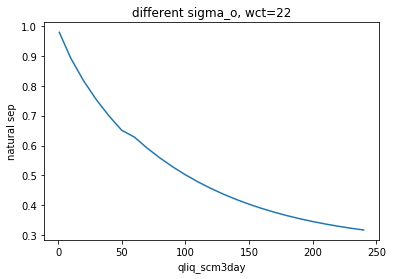

In [22]:
plt.plot(data['Q'],data['Естественная сепарация 100 мм'])
plt.ylabel('natural sep')
plt.xlabel('qliq_scm3day')
plt.title('different sigma_o, wct=22')

plt.show()

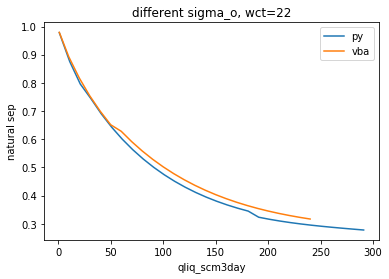

In [24]:
def getvalues(start=1,stop=300,step=10):
    q=[]
    sep=[]
    for i in range(start,stop,step):
        q.append(i)
        sep.append(sp.unf_calc_natural_separation(dintake_mm/1000,dcasing_mm/1000,
                                       i,
                                       qgas_scm3day(i*(1-wct_perc/100)),fluid.bo_m3m3,
                                       fluid.bg_m3m3,
                                       130/1000,fluid.rho_oil_stkgm3,
                                       fluid.rho_gas_sckgm3,wct_perc))
    return [q,sep]

result=getvalues()

plt.plot(result[0],result[1],label='py')
plt.plot(data['Q'],data['Естественная сепарация 100 мм'],label='vba')
plt.ylabel('natural sep')
plt.xlabel('qliq_scm3day')
plt.title('different sigma_o, wct=22')
plt.legend()
plt.show()